In [2]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.optimizers import Adam
import scipy.io
import matplotlib.pyplot as plt
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models, optimizers
from PIL import Image, ImageOps
from sklearn.model_selection import train_test_split

In [3]:
# Load pre-trained model without top classifier layers
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base model

model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='linear')
])

model.compile(optimizer=Adam(1e-4), loss='mse', metrics=['mae'])

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 9s 1us/step 


In [6]:
def load_dataset(image_dir, gt_dir, target_size=(224, 224)):
    X = []
    y = []
    image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]
    
    if not image_files:
        raise ValueError("Brak plików .jpg w podanym katalogu!")

    for img_file in image_files:
        img_path = os.path.join(image_dir, img_file)
        mat_path = os.path.join(gt_dir, 'GT_' + img_file.replace('.jpg', '.mat'))

        # Wczytaj obraz
        img = Image.open(img_path).convert('RGB')
        img_pil = img.copy()
        img_pil.thumbnail(target_size, Image.BICUBIC)

        # Padding
        delta_w = target_size[0] - img_pil.size[0]
        delta_h = target_size[1] - img_pil.size[1]
        padding = (delta_w // 2, delta_h // 2, delta_w - (delta_w // 2), delta_h - (delta_h // 2))
        img_padded = ImageOps.expand(img_pil, padding, fill=(0, 0, 0))

        # Konwersja do numpy i normalizacja
        img_array = np.array(img_padded) / 255.0  # Normalizacja [0, 1]

        # Wczytaj ground truth (liczba osób)
        mat = scipy.io.loadmat(mat_path)
        count = len(mat['image_info'][0][0][0][0][0])

        X.append(img_array)
        y.append(count)

    return np.array(X), np.array(y)

In [7]:
X_1, y_1 = load_dataset('ShanghaiTech/part_B/train_data/images/', 'ShanghaiTech/part_B/train_data/ground-truth/')

In [8]:
X_2, y_2 = load_dataset('ShanghaiTech/part_B/test_data/images/', 'ShanghaiTech/part_B/test_data/ground-truth/')

In [9]:
X = np.concatenate([X_1, X_2], axis=0)
y = np.concatenate([y_1, y_2], axis=0)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [11]:
training_set = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(32)

# Function to augment
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.1),
    RandomZoom(0.1),
])

def augment(x, y):
    return data_augmentation(x), y

training_set = tf.data.Dataset.from_tensor_slices((X_train, y_train))
training_set = training_set.map(augment)  # augment
training_set = training_set.batch(32).prefetch(tf.data.AUTOTUNE)
history = model.fit(training_set, batch_size=32,
    epochs=20, validation_data=(X_test, y_test)
)

Epoch 1/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - loss: 23823.2246 - mae: 122.0742 - val_loss: 17146.1484 - val_mae: 101.9714
Epoch 2/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 19s 838ms/step - loss: 19127.1758 - mae: 101.5389 - val_loss: 11848.1602 - val_mae: 77.1615
Epoch 3/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 19s 813ms/step - loss: 13681.3115 - mae: 80.7647 - val_loss: 7864.2231 - val_mae: 62.8273
Epoch 4/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 18s 789ms/step - loss: 10063.4014 - mae: 70.7772 - val_loss: 6782.5215 - val_mae: 62.5935
Epoch 5/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 18s 796ms/step - loss: 9054.6729 - mae: 71.0961 - val_loss: 6791.7090 - val_mae: 64.0936
Epoch 6/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 19s 725ms/step - loss: 8985.6992 - mae: 71.7019 - val_loss: 6779.4409 - val_mae: 63.7681
Epoch 7/20
16/23 ━━━━━━━━━━━━━━━━━━━━ 4s 675ms/step - loss: 8898.1543 - mae: 70.9255 


KeyboardInterrupt



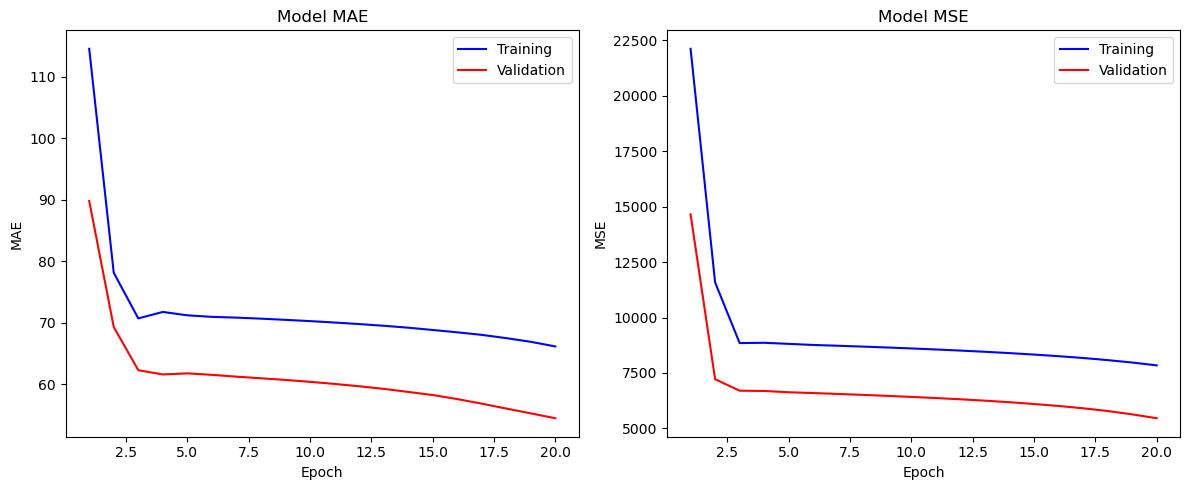

In [10]:
history_dict = history.history

# Getting the metrics
mae = history_dict['mae']
val_mae = history_dict.get('val_mae')
loss = history_dict['loss']
val_loss = history_dict.get('val_loss')

epochs = range(1, len(mae) + 1)

# MAE
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, mae, 'b-', label='Training')
if val_mae:
    plt.plot(epochs, val_mae, 'r-', label='Validation')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

# Loss (MSE)
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b-', label='Training')
if val_loss:
    plt.plot(epochs, val_loss, 'r-', label='Validation')
plt.title('Model MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()

plt.tight_layout()
plt.show()

In [11]:
y_pred = np.round(model.predict(X_test))

5/5 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step


In [12]:
y_pred.reshape(len(y_pred), 1)
y_test.reshape(len(y_test), 1)
print(np.concatenate((y_pred.reshape(len(y_pred), 1), y_test.reshape(len(y_test), 1)), 1))

[[115. 156.]
 [117. 267.]
 [ 96.  86.]
 [133. 143.]
 [134.  54.]
 [107.  36.]
 [ 86.  48.]
 [123.  42.]
 [137. 118.]
 [123. 281.]
 [109. 106.]
 [109.  35.]
 [145. 138.]
 [154. 251.]
 [ 97. 123.]
 [141. 146.]
 [133.  74.]
 [136. 129.]
 [115.  85.]
 [127. 176.]
 [113.  64.]
 [111.  28.]
 [134. 132.]
 [109.  93.]
 [134. 298.]
 [133. 217.]
 [111.  61.]
 [132. 111.]
 [107.  87.]
 [116.  53.]
 [117.  73.]
 [125.  94.]
 [134. 265.]
 [146. 166.]
 [104.  28.]
 [123.  68.]
 [124. 229.]
 [132. 165.]
 [106.  35.]
 [ 96.  66.]
 [129.  47.]
 [139. 132.]
 [108.  60.]
 [125. 150.]
 [117.  38.]
 [107.  79.]
 [138. 123.]
 [122.  57.]
 [ 83.  57.]
 [123.  94.]
 [134.  35.]
 [ 81.  21.]
 [125. 114.]
 [121. 203.]
 [ 92.  28.]
 [126.  51.]
 [150. 159.]
 [ 78.  36.]
 [123. 133.]
 [145. 155.]
 [131.  97.]
 [153. 277.]
 [ 90.  54.]
 [ 91.  25.]
 [ 91.  29.]
 [ 95.  80.]
 [125. 104.]
 [127. 107.]
 [122. 344.]
 [117. 205.]
 [107.  83.]
 [140. 132.]
 [117.  84.]
 [126. 164.]
 [146. 104.]
 [114. 142.]
 [153. 235.]

In [13]:
from sklearn.metrics import r2_score
r2_score(y_test, y_pred)

0.1925506591796875